<a href="https://colab.research.google.com/github/BlackPuma075/Advanced_Lab_2025/blob/main/Final%20Project/Final_Project_Advanced_Lab_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Matter Power Spectrum Catalog**

-Class computation of the spectra

-Variation on $\Omega_m$ only

-100 spectra catalog

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!apt-get install -y gfortran
!git clone https://github.com/lesgourg/class_public.git
%cd class_public
!make

# Volver al directorio base
%cd python
!python3 setup.py install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gfortran is already the newest version (4:11.2.0-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'class_public'...
remote: Enumerating objects: 31195, done.
remote: Total 31195 (delta 0), reused 0 (delta 0), pack-reused 31195 (from 2)
Receiving objects: 100% (31195/31195), 772.26 MiB | 19.23 MiB/s, done.
Resolving deltas: 100% (21623/21623), done.
/content/class_public
if ! [ -e /content/class_public/build ]; then mkdir /content/class_public/build ; mkdir /content/class_public/build/lib; fi;
touch build/.base
cd /content/class_public/build;gcc -O3 -pthread  -g -fPIC -D__CLASSDIR__='"/content/class_public"' -DHYREC -I../include -I../external/RecfastCLASS -I../external/heating -I../external/HyRec2020 -I../external/Halofit -I../external/HMcode -c ../tools/growTable.c -o growTable.o
cd /content/class_public/build;gcc -O3 -pthread  -g -fPIC -D__CLASSDIR__=

In [ ]:
from classy import Class

cosmo = Class()
cosmo.set({
    'h': 0.67,
    'omega_b': 0.022,
    'omega_cdm': 0.12,
    'A_s': 2.1e-9,
    'n_s': 0.96,
    'tau_reio': 0.06,
    'output': 'mPk',
    'P_k_max_1/Mpc': 10.0
})
cosmo.compute()

# Obtener espectro de potencia a z = 0
k_vals = [0.01, 0.1, 0.5]
for k in k_vals:
    print(f"P(k={k}) = {cosmo.pk(k, 0.0)}")

ks = np.logspace(-3, 1, 100)  # de 0.001 a 10 h/Mpc
Pk = [cosmo.pk(k, 0.0) for k in ks]

cosmo.struct_cleanup()
cosmo.empty()


In [ ]:
plt.figure(figsize=(8, 6))
plt.loglog(ks, Pk, label=r'$P(k)$ at $z=0$', color='cadetblue')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$', fontsize=12)
plt.ylabel(r'$P(k)\ [(\mathrm{Mpc}/h)^3]$', fontsize=12)
plt.title('Matter Power Spectrum from CLASS', fontsize=14)
#plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**Code snippet to create a catalog of 100 spectra**

In [ ]:
%%time
import numpy as np
from classy import Class
import matplotlib.pyplot as plt

# Valores fijos
h = 0.67
omega_b = 0.022
A_s = 2.1e-9
n_s = 0.96
tau = 0.06
z = 0.0
ks = np.logspace(-3, 1, 100)  #100 puntos entre 0.001 y 10 h/Mpc

#Rango de valores de Omega_m
Omega_m_vals = np.linspace(0.2, 0.4, 100)  # 100 valores entre 0.2 y 0.4

#Lista para almacenar los espectros
spectra = []

for Omega_m in Omega_m_vals:
    #Calcular omega_cdm necesario para ese Omega_m
    omega_cdm = Omega_m * h**2 - omega_b

    #Cosmología
    cosmo = Class()
    cosmo.set({
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': tau,
        'output': 'mPk',
        'P_k_max_1/Mpc': 10.0
    })

    #Calcular espectro
    cosmo.compute()
    Pk = [cosmo.pk(k, z) for k in ks]
    spectra.append(Pk)

    cosmo.struct_cleanup()
    cosmo.empty()

#'spectra' es una lista de 100 espectros con 100 valores de k cada uno


CPU times: user 2min 37s, sys: 2.18 s, total: 2min 40s
Wall time: 1min 37s


Time of execution: 00:01:03

**Neural Network**

-Imports

-Architechture

-Accuracy

In [ ]:
#Imports
import glob
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

In [33]:
Pks = np.array(spectra) #NN inputs
Omm_labels = Omega_m_vals #NN targets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Pks, Omm_labels, test_size=0.2, shuffle=True, random_state=1) #Random state to get the same shuffle every time

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape #Data shapes are already (nfeatures, nsamples)

((80, 100), (20, 100), (80,), (20,))

In [ ]:
#Normalization (Necessary?)
#scaler=preprocessing.StandardScaler().fit(X_train)
#X_scaled = scaler.transform(X_train)
#X_scaled.shape

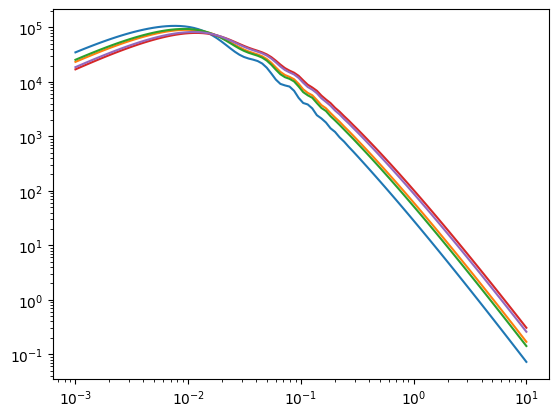

In [ ]:
#Variation in Pk's as Omm varies (Shuffle works)
plt.loglog(ks, X_train[0])
plt.loglog(ks, X_train[5])
plt.loglog(ks, X_train[7])
plt.loglog(ks,X_train[10])
plt.loglog(ks, X_train[50])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.neural_network import MLPRegressor

In [ ]:
#Testing multiple architectures at once
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(50,), (100, 50), (200, 100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(MLPRegressor(max_iter=1000), param_grid, cv=3)
grid.fit(X_train, y_train)

print("Mejor configuración:", grid.best_params_) #Best fit
print("Score en test:", grid.score(X_test, y_test)) #Can be arbitrary worse (negative values)

In [ ]:
model = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),  #Arquitectura: 3 capas ocultas con 200, 100 y 50 neuronas
    activation='tanh',             #Función de activación: 'relu', 'tanh', 'logistic'
    solver='adam',                 #Algoritmo de optimización: 'adam', 'sgd', 'lbfgs'
    alpha=1e-4,                    #Regularización (L2 penalty)
    learning_rate_init=0.001,      #Tasa de aprendizaje inicial
    max_iter=1000,                 #Número máximo de épocas
    random_state=42
)
model.fit(X_train,y_train)

#model.predict(X_test[:2])
model.score(X_test, y_test)

In [ ]:
print('Prediction: ',model.predict(X_test[4:5]),'True value: ',y_test[4])

In [ ]:
#Testing multiple architectures at once
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(200, 100, 50), (150, 150, 50)],
    'activation': ['tanh'],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(MLPRegressor(max_iter=1000), param_grid, cv=3)
grid.fit(X_train, y_train)

print("Mejor configuración:", grid.best_params_) #Best fit
print("Score en test:", grid.score(X_test, y_test)) #Can be arbitrary worse (negative values)

**Probé varias aqruitecturas no funcionó, al igual que modificar el tamaño del dataset. Tampoco cambiar el límite del número de onda mejoró la precisión.**

In [ ]:
model2 = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),  #Arquitectura: 3 capas ocultas con 200, 100 y 50 neuronas
    activation='tanh',             #Función de activación: 'relu', 'tanh', 'logistic'
    solver='lbfgs',                 #Algoritmo de optimización: 'adam', 'sgd', 'lbfgs'
    alpha=1e-4,                    #Regularización (L2 penalty)
    learning_rate_init=0.001,      #Tasa de aprendizaje inicial
    max_iter=1000,                 #Número máximo de épocas
    random_state=42
)
model2.fit(X_train,y_train)

#model.predict(X_test[:2])
model2.score(X_test, y_test)

**Cambiar el solver de 'adam' a 'lbgfs' mejora mucho la precisión a 98.6%**

Eso resuelve el problema del tamaño del dataset ya que el lbfgs solver está diseñado para datasets más compactos.

In [ ]:
print('Prediction: ',model2.predict(X_test[5:6]),'True value: ',y_test[5])

**Ahora que tenemos una buena precisión para un parámetro, correremos con $n_s$ libre, además de $\Omega_m$**

In [19]:
%%time
import numpy as np
from classy import Class
import matplotlib.pyplot as plt

# Valores fijos
h = 0.67
omega_b = 0.022
A_s = 2.1e-9
#n_s = 0.96
tau = 0.06
z = 0.0
ks = np.logspace(-3, 1, 100)  #100 puntos entre 0.001 y 10 h/Mpc

#Rango de valores de Omega_m
Omega_m_vals = np.linspace(0.2, 0.4, 100)  # 100 valores entre 0.2 y 0.4
ns_vals = np.linspace(0.95, 0.97,100)

#Lista para almacenar los espectros
spectra = []

for Omega_m in Omega_m_vals:
    #Calcular omega_cdm necesario para ese Omega_m
    omega_cdm = Omega_m * h**2 - omega_b

    for n_s in ns_vals:

      #Cosmología
      cosmo = Class()
      cosmo.set({
          'h': h,
          'omega_b': omega_b,
          'omega_cdm': omega_cdm,
          'A_s': A_s,
          'n_s': n_s,
          'tau_reio': tau,
          'output': 'mPk',
          'P_k_max_1/Mpc': 10.0
      })

    #Calcular espectro
    cosmo.compute()
    Pk = [cosmo.pk(k, z) for k in ks]
    spectra.append(Pk)

    cosmo.struct_cleanup()
    cosmo.empty()

#'spectra' es una lista de 100 espectros con 100 valores de k cada uno

CPU times: user 2min 37s, sys: 2.11 s, total: 2min 39s
Wall time: 1min 41s


*Para este caso los targets deben ser arrays 2D (nvals, 2)*

In [20]:
np.array([Omega_m_vals,ns_vals]).T.shape

(100, 2)

In [21]:
#np.array([Omega_m_vals,ns_vals]).T

In [22]:
Pks = np.array(spectra) #NN inputs
Labels = np.array([Omega_m_vals,ns_vals]).T #NN targets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Pks, Labels, test_size=0.2, shuffle=True, random_state=1) #Random state to get the same shuffle every time

X_train.shape, X_test.shape, y_train.shape, y_test.shape #Data shapes are already (nfeatures, nsamples)

((80, 100), (20, 100), (80, 2), (20, 2))

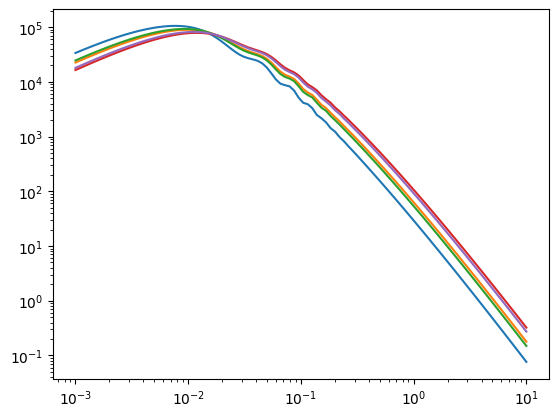

In [23]:
#Variation in Pk's as Omm varies (Shuffle works)
plt.loglog(ks, X_train[0])
plt.loglog(ks, X_train[5])
plt.loglog(ks, X_train[7])
plt.loglog(ks,X_train[10])
plt.loglog(ks, X_train[50])

In [24]:
#Testing multiple architectures at once
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(500,200,100,50),(200, 100, 50), (150, 150, 50)],
    'activation': ['tanh'],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(MLPRegressor(max_iter=1000), param_grid, cv=3)
grid.fit(X_train, y_train)

print("Mejor configuración:", grid.best_params_) #Best fit
print("Score en test:", grid.score(X_test, y_test)) #Can be arbitrary worse (negative values)

Mejor configuración: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (500, 200, 100, 50), 'learning_rate_init': 0.001}
Score en test: -28.11020276535904


Notamos que este dataset necesita una mayor densidad de neuronas

In [ ]:
model3 = MLPRegressor(
    hidden_layer_sizes=(500,200, 100, 50),  #Arquitectura: 3 capas ocultas con 200, 100 y 50 neuronas
    activation='tanh',             #Función de activación: 'relu', 'tanh', 'logistic'
    solver='lbfgs',                 #Algoritmo de optimización: 'adam', 'sgd', 'lbfgs'
    alpha=1e-4,                    #Regularización (L2 penalty)
    learning_rate_init=0.001,      #Tasa de aprendizaje inicial
    max_iter=1000,                 #Número máximo de épocas
    random_state=42
)
model3.fit(X_train,y_train)

#model.predict(X_test[:2])
model3.score(X_test, y_test)

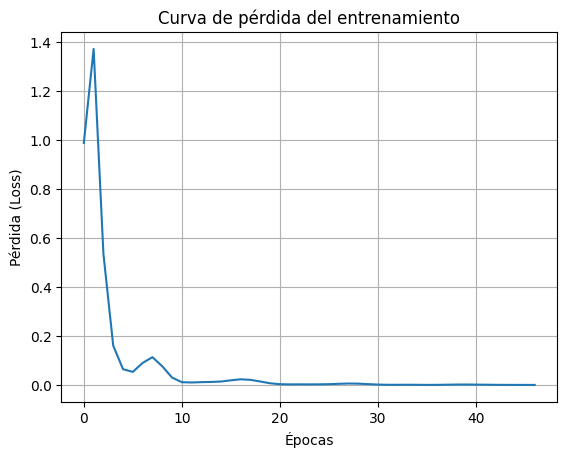

In [26]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

model3 = MLPRegressor(
    hidden_layer_sizes=(500, 200, 100, 50),
    activation='tanh',
    solver='adam',               # <--- Cambiado de 'lbfgs' a 'adam'
    alpha=1e-4,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

model3.fit(X_train, y_train)

# Graficar la curva de pérdida (solo del conjunto de entrenamiento)
plt.plot(model3.loss_curve_)
plt.title('Curva de pérdida del entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.grid()
plt.show()


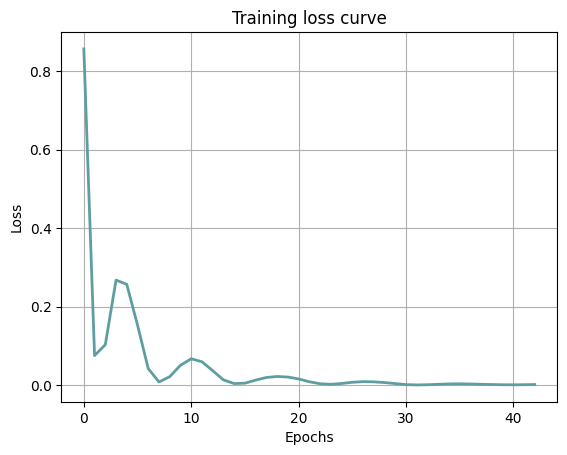

In [27]:
model.fit(X_train, y_train)

# Graficar la curva de pérdida (solo del conjunto de entrenamiento)
plt.plot(model.loss_curve_, color = 'cadetblue', lw=2)
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
#plt.savefig('Model1_cost_func.png')
plt.show()

In [28]:
from google.colab import files
#files.download("Model1_cost_func.png")

**Como este MLPRegressor no guarda el valor de la función costo en validación cambiaré a keras de aquí en adelante.**

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [30]:
tf.random.set_seed(1234)
model5 = Sequential(
    [
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(100, activation='relu', kernel_initializer='he_uniform', name = 'layer0'),
        Dropout(0.1),
        Dense(100, activation='relu',kernel_initializer='he_uniform', name = 'layer1'),
        Dropout(0.1),
        Dense(100, activation='relu',kernel_initializer='he_uniform', name = 'layer2'),
        Dropout(0.1),
        Dense(2, activation='linear',kernel_initializer='he_uniform', name = 'layer3'),
     ]
)
model5.summary()
model5.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer0 (Dense)                  │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,502 (119.15 KB)

 Trainable params: 30,502 (119.15 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history5 = model5.fit(
    X_train,y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

y_hat = model5.predict(X_test)
y_hat= (y_hat >= 0.5).astype(int)
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_hat - y_test)) * 100))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.6185 - loss: 1933113856.0000 - val_accuracy: 0.0000e+00 - val_loss: 287972032.0000
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4154 - loss: 1012353920.0000 - val_accuracy: 0.0000e+00 - val_loss: 107085688.0000
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5977 - loss: 827422464.0000 - val_accuracy: 1.0000 - val_loss: 56785224.0000
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7509 - loss: 664756672.0000 - val_accuracy: 0.0000e+00 - val_loss: 94710728.0000
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3806 - loss: 534218656.0000 - val_accuracy: 0.0000e+00 - val_loss: 149935904.0000
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3238 - loss: 555000064.0000 - val_accuracy: 0.0000e+00 - val_loss: 120689712.0000
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5022 - loss: 445338496.0000 - val_accuracy: 1.0000 - val_loss: 5326731

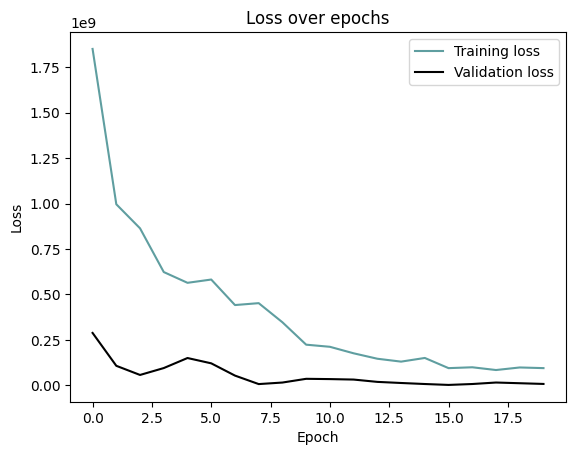

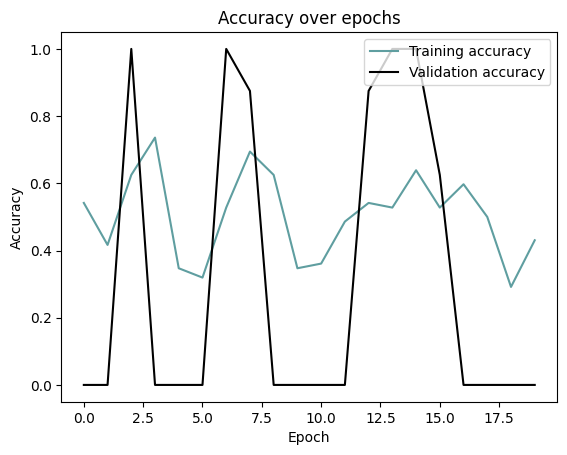

In [32]:
plt.plot(history5.history['loss'], label='Training loss', color ='cadetblue')
plt.plot(history5.history['val_loss'], label='Validation loss', color ='black')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('model4_loss.png')
plt.show()

# Precisión
plt.plot(history5.history['accuracy'], label='Training accuracy', color ='cadetblue')
plt.plot(history5.history['val_accuracy'], label='Validation accuracy', color ='black')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('model4_acc.png')
plt.show()

from google.colab import files
#files.download("model4_loss.png")
#files.download("model4_acc.png")

In [41]:
tf.random.set_seed(1234)
model6 = Sequential(
    [
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(200, activation='relu', kernel_initializer='he_uniform', name = 'layer0'),
        Dropout(0.1),
        Dense(100, activation='relu',kernel_initializer='he_uniform', name = 'layer1'),
        Dropout(0.1),
        Dense(50, activation='relu',kernel_initializer='he_uniform', name = 'layer2'),
        Dropout(0.1),
        Dense(2, activation='linear',kernel_initializer='he_uniform', name = 'layer3'),
     ]
)
model6.summary()
model6.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer0 (Dense)                  │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,452 (177.55 KB)

 Trainable params: 45,452 (177.55 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history6 = model6.fit(
    X_train,y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

y_hat = model6.predict(X_test)
y_hat= (y_hat >= 0.5).astype(int)
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_hat - y_test)) * 100))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.2999 - loss: 2429262080.0000 - val_accuracy: 1.0000 - val_loss: 1028306816.0000
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9232 - loss: 1071037440.0000 - val_accuracy: 1.0000 - val_loss: 92863328.0000
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5599 - loss: 527051168.0000 - val_accuracy: 0.0000e+00 - val_loss: 57354584.0000
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2313 - loss: 456125376.0000 - val_accuracy: 0.0000e+00 - val_loss: 34324444.0000
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4128 - loss: 346026048.0000 - val_accuracy: 1.0000 - val_loss: 32697310.0000
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6988 - loss: 177786656.0000 - val_accuracy: 1.0000 - val_loss: 18699956.0000
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5972 - loss: 158186784.0000 - val_accuracy: 1.0000 - val_loss: 27960422.0000
Epoch 8

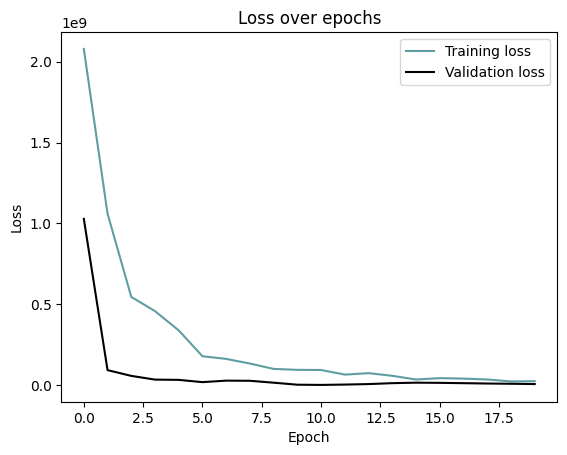

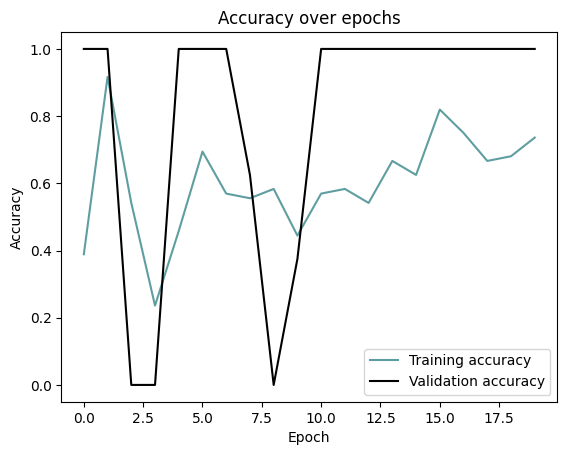

In [43]:
plt.plot(history6.history['loss'], label='Training loss', color ='cadetblue')
plt.plot(history6.history['val_loss'], label='Validation loss', color ='black')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('model4_loss.png')
plt.show()

# Precisión
plt.plot(history6.history['accuracy'], label='Training accuracy', color ='cadetblue')
plt.plot(history6.history['val_accuracy'], label='Validation accuracy', color ='black')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('model4_acc.png')
plt.show()

from google.colab import files
#files.download("model4_loss.png")
#files.download("model4_acc.png")

In [51]:
tf.random.set_seed(1234)
model7 = Sequential(
    [
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(100, activation='relu', kernel_initializer='he_uniform', name = 'layer1'),
        Dropout(0.1),
        Dense(50, activation='relu',kernel_initializer='he_uniform', name = 'layer2'),
        Dropout(0.1),
        Dense(25, activation='relu',kernel_initializer='he_uniform', name = 'layer3'),
        Dropout(0.1),
        Dense(2, activation='linear',kernel_initializer='he_uniform', name = 'layer4'),
     ]
)
model7.summary()
model7.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=['mae']
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,477 (64.36 KB)

 Trainable params: 16,477 (64.36 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history7 = model7.fit(
    X_train,y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

y_hat = model7.predict(X_test)
y_hat= (y_hat >= 0.5).astype(int)
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_hat - y_test)) * 100))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 172102544.0000 - mae: 10127.8770 - val_loss: 2507169.0000 - val_mae: 1403.7900
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 155532576.0000 - mae: 9693.5771 - val_loss: 2582900.2500 - val_mae: 1440.1416
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 114314328.0000 - mae: 7925.0625 - val_loss: 2130511.2500 - val_mae: 1275.0026
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 107945808.0000 - mae: 7715.8022 - val_loss: 2680365.0000 - val_mae: 1474.0144
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 142184704.0000 - mae: 9217.5996 - val_loss: 3994390.0000 - val_mae: 1754.5873
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 117951400.0000 - mae: 8286.7793 - val_loss: 5707041.5000 - val_mae: 1936.2505
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 140490528.0000 - mae: 9244.6328 - val_loss: 6386935.5000 - val_mae: 2012.7812
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - los

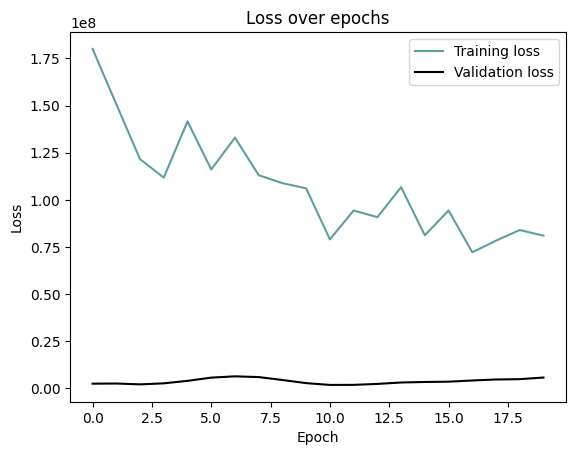

In [67]:
plt.plot(history7.history['loss'], label='Training loss', color ='cadetblue')
plt.plot(history7.history['val_loss'], label='Validation loss', color ='black')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('model4_loss.png')
plt.show()

from google.colab import files
#files.download("model4_loss.png")
#files.download("model4_acc.png")

**Parece que hay problemas debidos a la normalización, a partir de aquí normalizaré con StandardScaler**

In [56]:
from sklearn.preprocessing import StandardScaler

# Supongamos que X_train es (N, M) y y_train es (N, 2):
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled   = scaler_X.transform(X_test)

scaler_y = StandardScaler().fit(y_train)   # si quieres predecir en un rango parecido
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled   = scaler_y.transform(y_test)


In [68]:
tf.random.set_seed(1234)
from tensorflow.keras.layers import BatchNormalization

model8 = Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(2, activation='linear', kernel_initializer='he_uniform')
])

model8.summary()
model8.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,702 (123.84 KB)

 Trainable params: 31,102 (121.49 KB)

 Non-trainable params: 600 (2.34 KB)

In [69]:
history8 = model8.fit(
    X_train_scaled,y_train_scaled,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)

y_hat = model8.predict(X_test_scaled)
y_hat= (y_hat >= 0.5).astype(int)
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_hat - y_test_scaled)) * 100))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.4427 - loss: 2.2190 - val_accuracy: 0.0000e+00 - val_loss: 2.3517
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3989 - loss: 1.2278 - val_accuracy: 0.0000e+00 - val_loss: 1.2481
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4644 - loss: 0.4971 - val_accuracy: 0.3750 - val_loss: 0.8663
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3859 - loss: 0.4869 - val_accuracy: 0.5000 - val_loss: 0.9495
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3594 - loss: 0.4455 - val_accuracy: 0.5000 - val_loss: 0.9728
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4240 - loss: 0.5393 - val_accuracy: 0.5000 - val_loss: 0.7893
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4162 - loss: 0.4269 - val_accuracy: 0.5000 - val_loss: 0.5654
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5317 - loss: 0.3998 - val_accuracy: 0.5000 - val_loss

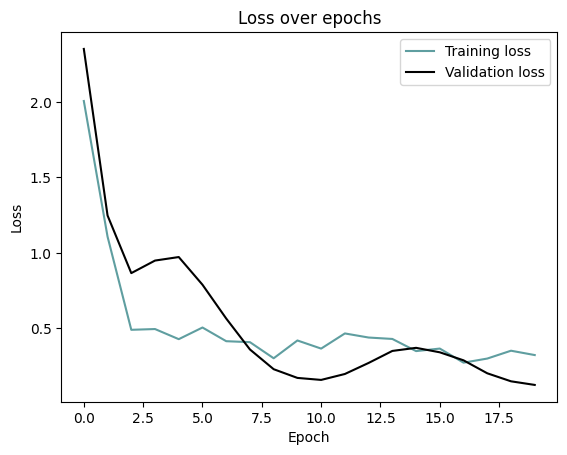

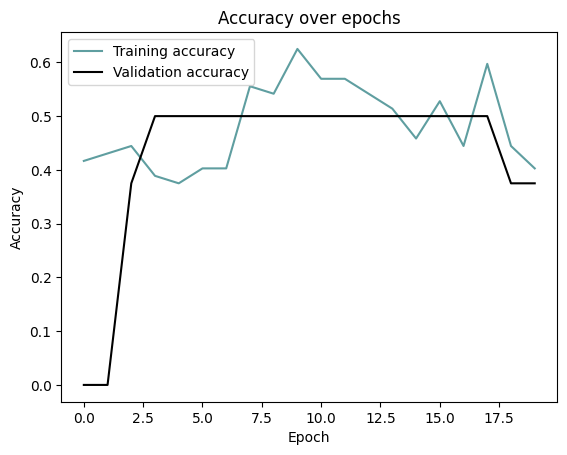

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
plt.plot(history8.history['loss'], label='Training loss', color ='cadetblue')
plt.plot(history8.history['val_loss'], label='Validation loss', color ='black')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('model8_loss.png')
plt.show()

# Precisión
plt.plot(history8.history['accuracy'], label='Training accuracy', color ='cadetblue')
plt.plot(history8.history['val_accuracy'], label='Validation accuracy', color ='black')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('model4_acc.png')
plt.show()

from google.colab import files
files.download("model8_loss.png")
#files.download("model4_acc.png")

**Normalization fixed. Turn the attention on to the architecture.**

***ALSO NOTE THAT THE ACCURACY VARIES IN A EXTRANGE MANER DUE TO THE IMPOSIBILITY OF PREDICTING THE EXACT VALUE FOR THE COSMOLOGICAL PARAMETER. FROM NOW ON I WILL ONLY PLOT THE LOSS FUNCTION***

In [188]:
tf.random.set_seed(1234)
from tensorflow.keras.layers import BatchNormalization

model9 = Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(2, activation='linear', kernel_initializer='he_uniform')
])

model9.summary()
model9.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=['mse']
)

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,702 (123.84 KB)

 Trainable params: 31,102 (121.49 KB)

 Non-trainable params: 600 (2.34 KB)

In [189]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history9 = model9.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    callbacks=[reduce_lr, early_stop]
)

eval_metrics = model9.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MSE: {eval_metrics[0]:.5e}")

y_hat_cont = model9.predict(X_test_scaled)
for i in range(5):
    print(f"Real: {y_test_scaled[i]}, Pred: {y_hat_cont[i]}")

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 1.8064 - mse: 1.8064 - val_loss: 0.8650 - val_mse: 0.8650 - learning_rate: 0.0010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.8593 - mse: 0.8593 - val_loss: 1.2204 - val_mse: 1.2204 - learning_rate: 0.0010
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.7909 - mse: 0.7909 - val_loss: 1.1523 - val_mse: 1.1523 - learning_rate: 0.0010
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5462 - mse: 0.5462 - val_loss: 0.8616 - val_mse: 0.8616 - learning_rate: 0.0010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6102 - mse: 0.6102 - val_loss: 0.6850 - val_mse: 0.6850 - learning_rate: 0.0010
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5227 - mse: 0.5227 - val_loss: 0.6459 - val_mse: 0.6459 - learning_rate: 0.0010
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4429 - mse: 0.4429 - val_loss: 0.7430 - val_mse: 0.7430 - learning_rate: 0.0010
Epoch 8/20
3/3 ━━━━━━━━━━━

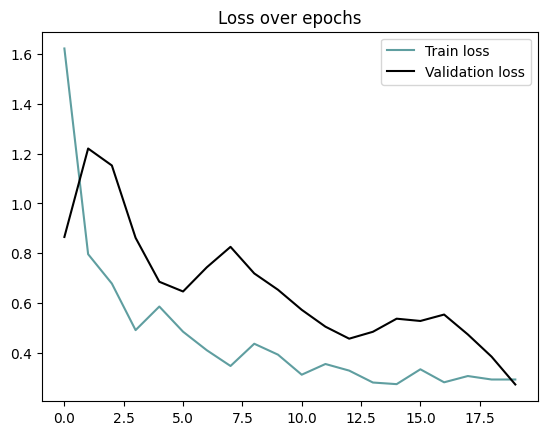

In [190]:
import matplotlib.pyplot as plt

# MSE
plt.plot(history9.history['loss'], label='Train loss', color ='cadetblue')
plt.plot(history9.history['val_mse'], label='Validation loss', color = 'black')
plt.legend()
plt.title('Loss over epochs')

#plt.savefig('model9_loss')
#files.download("model9_loss.png")

plt.show()

In [191]:
y_test_real = scaler_y.inverse_transform(y_test_scaled)
y_pred_real = scaler_y.inverse_transform(y_hat_cont)
from sklearn.metrics import mean_squared_error

mse_real = mean_squared_error(y_test_real, y_pred_real)
print(f"Descaled MSE: {mse_real}")

Descaled MSE: 0.0001318181315440641


In [192]:
np.sqrt(mse_real)

np.float64(0.011481207756332263)

**El MSE obtenido antes de 117 era un valor dado por los rescalamientos de los datos, al hacer el escalamiento inverso y calcular el MSE obtuve 0.0004499 que es un error de $\pm0.0133$ lo cual es totalmente razonable para estos parámetros cosmológicos.**